In [386]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
import re

In [399]:
#Read in Data
game_data = pd.read_csv('game_data.csv')
play_info = pd.read_csv('play_information.csv')
play_player_role = pd.read_csv('play_player_role_data.csv')
player_punt = pd.read_csv('player_punt_data.csv')
video_footage_control = pd.read_csv('video_footage-control.csv')
video_footage_injury = pd.read_csv('video_footage-injury.csv')
video_review = pd.read_csv('video_review.csv')

In [3]:
NGS_2016_pre = pd.read_csv('NGS-2016-pre.csv')
NGS_2016_post = pd.read_csv('NGS-2016-post.csv')
NGS_2017_pre = pd.read_csv('NGS-2017-pre.csv')
NGS_2017_post = pd.read_csv('NGS-2017-post.csv')

In [4]:
NGS_2016_wk1_6 = pd.read_csv('NGS-2016-reg-wk1-6.csv')
NGS_2016_wk7_12 = pd.read_csv('NGS-2016-reg-wk7-12.csv')
NGS_2016_wk13_17 = pd.read_csv('NGS-2016-reg-wk13-17.csv')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# NGS_2017_wk1_6 = pd.read_csv('NGS-2017-reg-wk1-6.csv')
# NGS_2017_wk7_12 = pd.read_csv('NGS-2017-reg-wk7-12.csv')
# NGS_2017_wk13_17 = pd.read_csv('NGS-2017-reg-wk13-17.csv')

In [5]:
NGS_2016 = pd.concat([NGS_2016_wk1_6, NGS_2016_wk7_12, NGS_2016_wk13_17])

In [ ]:
# NGS_2017 = pd.concat([NGS_2017_wk1_6, NGS_2017_wk7_12, NGS_2017_wk13_17])

In [330]:
# NGS_df = pd.concat([NGS_2016, NGS_2017])

### EDA

In [342]:
'There are concussion injuries on ' + str(round(len(video_review) / float(len(play_info)) * 100, 2)) + '% of ' + 'punt plays'

'There are concussion injuries on 0.55% of punt plays'

##### It is good for the NFL and players that injuries only occure on less than 1% of punt plays, but it will be hard to do analysis

#### How are players being injured?

In [385]:
trace1 = go.Bar(
        x=video_review.groupby(['Player_Activity_Derived'], as_index=False)['PlayID'].count()['Player_Activity_Derived'],
        y=video_review.groupby(['Player_Activity_Derived'], as_index=False)['PlayID'].count()['PlayID']
    )
trace2 = go.Bar(
        x=video_review.groupby(['Primary_Impact_Type'], as_index=False)['PlayID'].count()['Primary_Impact_Type'],
        y=video_review.groupby(['Primary_Impact_Type'], as_index=False)['PlayID'].count()['PlayID'],
    )
trace3 = go.Bar(
        x=video_review.groupby(['Friendly_Fire'], as_index=False)['PlayID'].count()['Friendly_Fire'],
        y=video_review.groupby(['Friendly_Fire'], as_index=False)['PlayID'].count()['PlayID'],
    )
trace4 = go.Bar(
        x=video_review.groupby(['Primary_Partner_Activity_Derived'], as_index=False)['PlayID'].count()['Primary_Partner_Activity_Derived'],
        y=video_review.groupby(['Primary_Partner_Activity_Derived'], as_index=False)['PlayID'].count()['PlayID'],
    )

fig = tools.make_subplots(rows=2, cols=2, subplot_titles=('Player Activity Derived', 'Primary Impact Type',
                                                          'Friendly Fire', 'Primary Partner Activity Derived'))

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 2)

fig['layout'].update(showlegend=False)

py.iplot(fig, filename='make-subplots-multiple-with-titles')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



### Quick Conclusions
    - No player activity stands out
    - Helmet to player is primary impact type
    - Friendly fire is only clear 16% of the time
    - No Partner Activity Stands Out

### On what type of plays are players getting hurt?

In [405]:
#Create a column in the play_info dataframe to determine the type of play
play_info['outcome'] = np.where(play_info['PlayDescription'].str.contains('fair catch', flags=re.IGNORECASE, regex=True), 'fair_catch',
                        np.where(play_info['PlayDescription'].str.contains('touchback', flags=re.IGNORECASE, regex=True), 'touchback',
                        np.where(play_info['PlayDescription'].str.contains('out of bounds', flags=re.IGNORECASE, regex=True), 'oob',
                        np.where(play_info['PlayDescription'].str.contains('downed', flags=re.IGNORECASE, regex=True), 'downed',
                        np.where(play_info['PlayDescription'].str.contains('blocked', flags=re.IGNORECASE, regex=True), 'blocked',
                        np.where(play_info['PlayDescription'].str.contains('fake|pass', flags=re.IGNORECASE, regex=True), 'fake', 
                        np.where(play_info['PlayDescription'].str.contains('safety', flags=re.IGNORECASE, regex=True), 'safety',
                        np.where(play_info['PlayDescription'].str.contains('[0-9]+ for [-+]?[0-9]+ yards?|for no gain|muffs|touchdown', flags=re.IGNORECASE, regex=True), 'return',         
                        np.where(play_info['PlayDescription'].str.contains('- no play|delay of game|false start, declined|penalty enforced', flags=re.IGNORECASE, regex=True), 'no_play', ' ')))))))))

In [410]:
vr_merged = play_info.merge(video_review, how='inner', on =['Season_Year', 'GameKey', 'PlayID'])

In [416]:
vr_merged.outcome.value_counts()

return        32
downed         3
fair_catch     2
Name: outcome, dtype: int64

#### conclusion: players are getting hurt on returns 

In [414]:
#Is it a higher proportion compared to all plays?

In [415]:
play_info.outcome.value_counts()

return        2917
fair_catch    1663
downed         802
oob            696
touchback      407
no_play        139
blocked         26
fake            25
safety           6
Name: outcome, dtype: int64

In [417]:
32.0 / 2917

0.010970174837161468

In [418]:
2.0 / 1663

0.0012026458208057728

In [419]:
3.0 / 802

0.003740648379052369

#### Who's getting hurt?

In [ ]:
merged_df = video_review.merge(play_player_role, how= 'left', left_on=['GSISID','PlayID','GameKey'], right_on=['GSISID','PlayID','GameKey'])

In [ ]:
player_punt.loc[player_punt.GSISID == 32482]

In [ ]:
play_player_role.loc[(play_player_role.GSISID == 29343) & (play_player_role.PlayID == 2587)]

In [ ]:
merged_df.Role.value_counts()

In [ ]:
len(video_footage_injury)

In [ ]:
ax = plt.plot(test_plot['x'],test_plot['y'])

In [ ]:
gunner_df = NGS_2016_pre.loc[(NGS_2016_pre.GameKey == 5) & (NGS_2016_pre.PlayID == 3129) & (NGS_2016_pre.GSISID == 31057)].sort_values('Time')

In [ ]:
min(gunner_df['Time'])

In [ ]:
max(gunner_df['Time'])

In [ ]:
gunner_df.head(11).dis.sum() * 2.045

In [ ]:
gunner_df.head()

In [ ]:
gunner_df['dis_per_second'] = gunner_df.dis * 10
gunner_df['dis_mph'] = gunner_df['dis_per_second'] * 2.0455

In [ ]:
print(gunner_df.dis_mph[200:250])

In [ ]:
play_player_role.loc[(play_player_role.GameKey == 5) & (play_player_role.PlayID == 3129) & (play_player_role.GSISID == 31057)]

In [ ]:
ax1 = plt.subplot()
ax1.plot(gunner_df['x'], gunner_df['y'])
ax1.set_xlim([0,120])
ax1.set_ylim([0,53.3])

In [ ]:
max(NGS_2016_wk1_6['y'])

In [ ]:
play_info['fair_catch'] = play_info.PlayDescription.str.contains('fair catch')

In [ ]:
play_info.loc[play_info.fair_catch == True].merge(video_review)

In [ ]:
video_footage_injury.loc[video_footage_injury.playid == 2918]

In [ ]:
video_footage_injury.head()

### Does speed correlate with injury?

In [ ]:
video_review.head()

In [ ]:
injury_ngs = video_review.merge(NGS_2016, how ='inner', left_on=['GSISID','PlayID','GameKey'], right_on=['GSISID','PlayID','GameKey'])

In [ ]:
injury_ngs['dis_per_second'] = injury_ngs.dis * 10
injury_ngs['dis_mph'] = injury_ngs.dis_per_second * 2.0455

In [ ]:
injury_ngs.groupby('PlayID')['dis_mph'].agg(max)

In [ ]:
play_info.head()

In [ ]:
play_info = play_info.merge(video_review[['GameKey','PlayID','GSISID']], how = 'left', left_on = ['GameKey','PlayID'], right_on = ['GameKey','PlayID'])

In [ ]:
play_info['injury'] = play_info.GSISID.apply(lambda x: 0 if pd.isnull(x) else 1)

In [ ]:
play_info.fair_catch.value_counts(normalize = True)

In [ ]:
play_info.loc[play_info.injury == 1]['fair_catch'].sum() / len(play_info.loc[play_info.injury == 1])

In [ ]:
play_info.loc[play_info.injury == 1]['fair_catch'].sum() / len(play_info.loc[play_info.injury == 0])

In [ ]:
fair_catches = play_info.loc[play_info.fair_catch == 1]
non_fair_catches = play_info.loc[play_info.fair_catch == 0]

In [ ]:
len(fair_catches.loc[fair_catches.injury == 1]) / float(len(fair_catches)) * 100

In [ ]:
len(non_fair_catches.loc[non_fair_catches.injury == 1]) / float(len(non_fair_catches)) * 100

In [ ]:
(.7-.12) / .12

#### Nearly 5 times more likely to have an injury when there is an actual return

In [ ]:
import plotly

In [ ]:
import plotly.graph_objs as go
from plotly import offline
import plotly.plotly as py
plotly.tools.set_credentials_file(username='mtodisco10', api_key='bCfUmq5FralbymKXY4uX')

In [ ]:
def load_layout():
    """
    Returns a dict for a Football themed Plot.ly layout 
    """
    layout = dict(
        title = "Player Activity",
        plot_bgcolor='darkseagreen',
        showlegend=True,
        xaxis=dict(
            autorange=False,
            range=[0, 120],
            showgrid=False,
            zeroline=False,
            showline=True,
            linecolor='black',
            linewidth=1,
            mirror=True,
            ticks='',
            tickmode='array',
            tickvals=[10,20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
            ticktext=['Goal', 10, 20, 30, 40, 50, 40, 30, 20, 10, 'Goal'],
            showticklabels=True
        ),
        yaxis=dict(
            title='',
            autorange=False,
            range=[-3.3,56.3],
            showgrid=False,
            zeroline=False,
            showline=True,
            linecolor='black',
            linewidth=1,
            mirror=True,
            ticks='',
            showticklabels=False
        ),
        shapes=[
            dict(
                type='line',
                layer='below',
                x0=0,
                y0=0,
                x1=120,
                y1=0,
                line=dict(
                    color='white',
                    width=2
                )
            ),
            dict(
                type='line',
                layer='below',
                x0=0,
                y0=53.3,
                x1=120,
                y1=53.3,
                line=dict(
                    color='white',
                    width=2
                )
            ),
            dict(
                type='line',
                layer='below',
                x0=10,
                y0=0,
                x1=10,
                y1=53.3,
                line=dict(
                    color='white',
                    width=10
                )
            ),
            dict(
                type='line',
                layer='below',
                x0=20,
                y0=0,
                x1=20,
                y1=53.3,
                line=dict(
                    color='white'
                )
            ),
            dict(
                type='line',
                layer='below',
                x0=30,
                y0=0,
                x1=30,
                y1=53.3,
                line=dict(
                    color='white'
                )
            ),
            dict(
                type='line',
                layer='below',
                x0=40,
                y0=0,
                x1=40,
                y1=53.3,
                line=dict(
                    color='white'
                )
            ),
            dict(
                type='line',
                layer='below',
                x0=50,
                y0=0,
                x1=50,
                y1=53.3,
                line=dict(
                    color='white'
                )
            ),
            dict(
                type='line',
                layer='below',
                x0=60,
                y0=0,
                x1=60,
                y1=53.3,
                line=dict(
                    color='white'
                )
            ),dict(
                type='line',
                layer='below',
                x0=70,
                y0=0,
                x1=70,
                y1=53.3,
                line=dict(
                    color='white'
                )
            ),dict(
                type='line',
                layer='below',
                x0=80,
                y0=0,
                x1=80,
                y1=53.3,
                line=dict(
                    color='white'
                )
            ),
            dict(
                type='line',
                layer='below',
                x0=90,
                y0=0,
                x1=90,
                y1=53.3,
                line=dict(
                    color='white'
                )
            ),dict(
                type='line',
                layer='below',
                x0=100,
                y0=0,
                x1=100,
                y1=53.3,
                line=dict(
                    color='white'
                )
            ),
            dict(
                type='line',
                layer='below',
                x0=110,
                y0=0,
                x1=110,
                y1=53.3,
                line=dict(
                    color='white',
                    width=10
                )
            )
        ]
    )
    return layout

layout = load_layout()

In [ ]:
# Loading and plotting functions

def load_plays_for_game(GameKey):
    """
    Returns a dataframe of play data for a given game (GameKey)
    """
    play_information = pd.read_csv('play_information.csv')
    play_information = play_information[play_information['GameKey'] == GameKey]
    return play_information


def load_game_and_ngs(ngs_file=None, GameKey=None):
    """
    Returns a dataframe of player movements (NGS data) for a given game
    """
    if ngs_file is None:
        print("Specifiy an NGS file.")
        return None
    if GameKey is None:
        print('Specify a GameKey')
        return None
    # Merge play data with NGS data    
    plays = load_plays_for_game(GameKey)
    ngs = pd.read_csv(ngs_file, low_memory=False)
    merged = pd.merge(ngs, plays, how="inner", on=["GameKey", "PlayID", "Season_Year"])
    return merged


def plot_play(game_df, PlayID, player1=None, player2=None, custom_layout=False):
    """
    Plots player movements on the field for a given game, play, and two players
    """
    game_df = game_df[game_df.PlayID==PlayID]
    
    GameKey=str(pd.unique(game_df.GameKey)[0])
    HomeTeam = pd.unique(game_df.Home_Team_Visit_Team)[0].split("-")[0]
    VisitingTeam = pd.unique(game_df.Home_Team_Visit_Team)[0].split("-")[1]
    YardLine = game_df[(game_df.PlayID==PlayID) & (game_df.GSISID==player1)]['YardLine'].iloc[0]
    
    traces=[]   
    if (player1 is not None) & (player2 is not None):
        game_df = game_df[ (game_df['GSISID']==player1) | (game_df['GSISID']==player2)]
        for player in pd.unique(game_df.GSISID):
            player = int(player)
            trace = go.Scatter(
                x = game_df[game_df.GSISID==player].x,
                y = game_df[game_df.GSISID==player].y,
                name='GSISID '+str(player),
                mode='markers'
            )
            traces.append(trace)
    else:
        print("Specify GSISIDs for player1 and player2")
        return None
    
    if custom_layout is not True:
        layout = load_layout()
        layout['title'] =  HomeTeam + \
        ' vs. ' + VisitingTeam + \
        '<br>Possession: ' + \
        YardLine.split(" ")[0] +'@'+YardLine.split(" ")[1]
    data = traces
    fig = dict(data=data, layout=layout)
    play_description = game_df[(game_df.PlayID==PlayID) & (game_df.GSISID==player1)].iloc[0]["PlayDescription"]
    print("\n\n\t",play_description)
    #py.iplot(fig,filename='jupyter-table1')
    offline.iplot(fig)

In [ ]:
game280 = load_game_and_ngs('NGS-2016-reg-wk13-17.csv',GameKey=280)

In [ ]:
plot_play(game_df=game280, PlayID=2918, player1=32120, player2=32725)

In [ ]:
video_review.head()

In [ ]:
player = NGS_2016_pre.loc[(NGS_2016_pre.PlayID == 3129) & (NGS_2016_pre.GSISID == 31057) 
                          & (NGS_2016_pre.GameKey == 5)] 


In [ ]:
partner = NGS_2016_pre.loc[(NGS_2016_pre.PlayID == 3129) & (NGS_2016_pre.GSISID == 32482) & 
                           (NGS_2016_pre.GameKey == 5)] 

In [ ]:
player.loc[player.Event.notnull()].sort_values('Time')

In [ ]:
partner.loc[partner.Time == '2016-08-12 02:07:48.300']

In [ ]:
player = player[['x','y','dis']]

In [ ]:
partner.sort_values('Time').head()

In [ ]:
player_partner 

In [ ]:
next_gen_data.head()

In [ ]:
#MAX_Speed, AVG_Speed

In [ ]:
next_gen_data = pd.read_csv('NGS-2016-pre.csv')

In [ ]:
playId = 3129
gameKey = 5
gsisid = 31057

In [ ]:
play_info.loc[(play_info.GameKey == gameKey) & (play_info.PlayID == playId)]

In [ ]:
video_review.loc[(video_review.PlayID == playId)]

In [ ]:
def get_speed(ng_data, playId, gameKey, player, partner):
    ng_data = pd.read_csv(ng_data)
    ng_data['mph'] = convert_to_mph(ng_data['dis'], 20.455)
    player_data = ng_data.loc[(ng_data.GameKey == gameKey) & (ng_data.PlayID == playId) 
                               & (ng_data.GSISID == player)].sort_values('Time')
    partner_data = ng_data.loc[(ng_data.GameKey == gameKey) & (ng_data.PlayID == playId) 
                              & (ng_data.GSISID == partner)].sort_values('Time')
    player_grouped = player_data.groupby(['GameKey','PlayID','GSISID'], 
                               as_index = False)['mph'].agg({'max_mph': max,
                                                             'avg_mph': np.mean
                                                            })
    player_grouped['involvement'] = 'player_injured'
    partner_grouped = partner_data.groupby(['GameKey','PlayID','GSISID'], 
                               as_index = False)['mph'].agg({'max_mph': max,
                                                             'avg_mph': np.mean
                                                            })
    partner_grouped['involvement'] = 'primary_partner'
    return pd.concat([player_grouped, partner_grouped], axis = 0)[['involvement',
                                                                   'max_mph',
                                                                   'avg_mph']].reset_index(drop=True)

In [ ]:
def convert_to_mph(dis_vector, converter):
    mph_vector = dis_vector * converter
    return mph_vector

In [ ]:
get_speed('NGS-2016-pre.csv', 3129, 5, 31057, 32482)

### Identify 2 gunner blockers

In [ ]:
# for each game,  count how many players are gunner blockers.
# does this correlate with more returns?  more injuries?

In [ ]:
gunners = NGS_2016

In [ ]:
gunners.head()

In [ ]:
rank_df = gunners.loc[(gunners.Season_Year == 2016) & (gunners.Event == 'ball_snap')].sort_values('Time')

In [ ]:
rank_df['rank'] = rank_df.groupby(['Season_Year','GameKey','PlayID','GSISID']).cumcount() +1

In [ ]:
rank_df = rank_df.loc[rank_df['rank'] == 1]

In [ ]:
g_merge = rank_df.merge(play_player_role, how = 'inner', on = ['Season_Year','GameKey','PlayID','GSISID'])

In [ ]:
# ax1 = plt.subplot()
# ax1.scatter(g_merge.loc[g_merge.Event == 'line_set']['x'].reset_index(drop=True)
#             ,g_merge.loc[g_merge.Event == 'line_set']['y'].reset_index(drop=True))
# ax1.set_xlim([0,120])
# ax1.set_ylim([0,53.3])
# for i, txt in enumerate(g_merge.loc[g_merge.Event == 'line_set'].reset_index(drop=True)['Role']):
#     ax1.annotate(txt,xy=(g_merge.loc[g_merge.Event == 'line_set']['x'].reset_index(drop=True)[i]
#                            ,g_merge.loc[g_merge.Event == 'line_set']['y'].reset_index(drop=True)[i]))

In [11]:
return_roles = ['PDL1','PDL2','PDL3','PDL4','PDL5','PDL6','PDM','PDR1','PDR2','PDR3','PDR4','PDR5','PDR6'
                ,'PFB','PLL','PLL1','PLL2','PLL3','PLM','PLM1','PLR','PLR1','PLR2','PLR3','PR','VL','VLi'
                ,'VLo','VR','VRi','VRo']

coverage_roles = ['GL','GLi','GLo','GR','GRi','GRo','P','PC','PLG','PLS','PLT','PLW','PPL','PPLi','PPLo'
                 ,'PPR','PPRi','PPRo','PRG','PRT','PRW']

In [288]:
gunner_blockers = ['VL','VLi','VLo','VR','VRi','VRo']

In [ ]:
g_pre_snap = g_merge.loc[(g_merge['Role'].isin(gunner_blockers)) & (g_merge['Event'] == 'ball_snap')]

In [ ]:
gunner_blockers_per_play = g_pre_snap.groupby(['Season_Year','GameKey','PlayID'], as_index=False)['Role'] \
    .agg({'gunner_blocker_count': 'count'})\
    .sort_values('gunner_blocker_count', ascending =False)

In [ ]:
gunner_blockers_merged = gunner_blockers_per_play.merge(play_info, how ='left', on = ['Season_Year','GameKey','PlayID'])

In [ ]:
gunner_blockers_merged['fair_catch'] = gunner_blockers_merged.PlayDescription.str.contains('fair catch')

In [ ]:
gunner_summary = gunner_blockers_merged.groupby(['gunner_blocker_count'], as_index = False)['fair_catch'].agg([sum,'count'])

In [ ]:
gunner_summary['perc'] = gunner_summary['sum'] / gunner_summary['count']

In [ ]:
gunner_summary

In [ ]:
gunner_summary_injury = gunner_blockers_merged.merge(video_footage_injury, how='inner', 
                             left_on = ['Season_Year','GameKey','PlayID'],
                            right_on = ['season','gamekey','playid']) \
                            .groupby(['gunner_blocker_count'], as_index = False)['fair_catch'].agg([sum,'count'])

In [ ]:
gunner_summary_injury['perc'] = gunner_summary_injury['sum'] / gunner_summary_injury['count']

In [ ]:
gunner_summary_injury

In [ ]:
video_footage_injury.head()

In [ ]:
play_player_role.loc[(play_player_role.Season_Year == 2016) & (play_player_role.GameKey == 280)
                     & (play_player_role.PlayID == 2918)]

In [ ]:
test_play = NGS_2016.loc[(NGS_2016.GameKey == 280) & (NGS_2016.PlayID == 2918)]\
    .sort_values('Time').reset_index(drop=True)

In [ ]:
from datetime import datetime

In [ ]:
single_play_events = NGS_2016.loc[(NGS_2016.GameKey == 280) & (NGS_2016.PlayID == 2918)]\
    .groupby(['Time','Event'], as_index=False)\
    .count().sort_values('Time')

single_play_events['datetime'] = pd.to_datetime(single_play_events['Time'], format='%Y-%m-%d %H:%M:%S.%f')

In [ ]:
test_play['Time'] = pd.to_datetime(test_play['Time'], format='%Y-%m-%d %H:%M:%S.%f')

In [ ]:
val = single_play_events.loc[single_play_events.Event == 'punt']['datetime']  \
              - pd.Timedelta(seconds=4)

In [ ]:
import math

In [ ]:
from scipy.spatial import distance

In [ ]:
def euclid_distance(x1, y1, x2, y2):
  # Euclidean distance between points.
    dist = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    return dist

In [ ]:
test_returner = test_play.loc[(test_play.Event == 'fair_catch') & (test_play.GSISID == 33127)].reset_index(drop=True)

In [ ]:
test_returner['x'], test_returner['y']

In [ ]:
test_players = test_play.loc[test_play.Time ==val.reset_index(drop=True)[0]].reset_index()

In [ ]:
dist_lst = []
for i in range(0, len(test_players)):
    coords = test_players['x'][i], test_players['y'][i]
    dist = euclid_distance(test_returner['x'][0], test_returner['y'][0], coords[0], coords[1])
    dist_lst.append(dist)

In [ ]:
test_players['dist_lst'] = dist_lst

In [ ]:
test_players.head()

In [ ]:
NGS_2016.Event.value_counts()

### Calculate hang time of punts

In [ ]:
punt_event = NGS_2016.loc[NGS_2016.Event == 'punt'].groupby(['Season_Year', 'GameKey','PlayID'], as_index = False)['Time'].min()
punt_event.rename(columns = {'Time':'punt_time'}, inplace=True)
punt_event['punt_time'] = pd.to_datetime(punt_event['punt_time'], format='%Y-%m-%d %H:%M:%S.%f')

In [ ]:
received_event = NGS_2016.loc[(NGS_2016.Event == 'punt_received') | (NGS_2016.Event == 'fair_catch')].groupby(['Season_Year', 'GameKey','PlayID'], as_index = False)['Time'].min()
received_event.rename(columns = {'Time':'received_time'}, inplace=True)
received_event['received_time'] = pd.to_datetime(received_event['received_time'], format='%Y-%m-%d %H:%M:%S.%f')

In [ ]:
punt_df = punt_event.merge(received_event, how='inner', on = ['Season_Year','GameKey','PlayID'])

In [ ]:
punt_df['hang_time'] = punt_df['received_time'] - punt_df['punt_time']

In [ ]:
(punt_df['hang_time'].astype(int) / 1000000000).hist()

In [ ]:
str(punt_df['hang_time'].mean().seconds) + '.' + str(punt_df['hang_time'].mean().microseconds)[:2]

In [ ]:
str(punt_df['hang_time'].median().seconds) + '.' + str(punt_df['hang_time'].median().microseconds)[:2]

### Calculate distance between returner and closest coverage man

In [ ]:
test_play = NGS_2016.loc[(NGS_2016.GameKey == 280) & (NGS_2016.PlayID == 2918)]\
    .sort_values('Time').reset_index(drop=True)

In [ ]:
test_play_merged = test_play.merge(play_player_role, how='inner', on = ['Season_Year','GameKey','PlayID','GSISID'])
test_play_merged['Time'] = pd.to_datetime(test_play_merged['Time'], format='%Y-%m-%d %H:%M:%S.%f')

In [ ]:
punt_event_time = test_play_merged.loc[test_play_merged.Event == 'punt'].Time.min()
receiving_event_time = test_play_merged.loc[(test_play_merged.Event == 'punt_received') | (test_play_merged.Event == 'fair_catch')].Time.min()

In [ ]:
coverage_test = test_play_merged.loc[test_play_merged['Role'].isin(coverage_roles)].sort_values('Time')
coverage_test.rename(columns={'x':'cov_x', 
                              'y': 'cov_y',
                              'GSISID': 'cov_GSISID',
                              'dis': 'cov_dis',
                              'o': 'cov_o',
                              'dir': 'cov_dir',
                              'Role': 'cov_Role'
                             }, inplace=True)

In [ ]:
returner_test = test_play_merged.loc[test_play_merged['Role'] == 'PR'].sort_values('Time')
returner_test.rename(columns={'x':'ret_x', 
                              'y': 'ret_y',
                              'GSISID': 'ret_GSISID',
                              'dis': 'ret_dis',
                              'o': 'ret_o',
                              'dir': 'ret_dir',
                              'Role': 'ret_Role'
                             }, inplace=True)

returner_test = returner_test.drop('Event', axis = 1)

In [ ]:
cov_ret = coverage_test.merge(returner_test, how ='inner', on = ['Season_Year','GameKey','PlayID','Time'])

In [ ]:
cov_ret['dis_from_ret'] = ((cov_ret['cov_x'] -  cov_ret['ret_x']) ** 2 + (cov_ret['cov_y'] -  cov_ret['ret_y']) ** 2).apply(np.sqrt)

In [ ]:
cov_ret.loc[cov_ret['Time'] == (punt_event_time + pd.Timedelta(seconds=20))].sort_values('dis_from_ret')

In [ ]:
punt_event_time + pd.Timedelta(seconds=4)

In [ ]:
dist_dict = {}

In [ ]:
dist_dict['2918'] = {}

In [ ]:
for i in range(1, 5):
    time_df = cov_ret.loc[cov_ret['Time'] == (punt_event_time + pd.Timedelta(seconds=i))].sort_values('dis_from_ret').reset_index()
    cov_role = time_df['cov_Role'][0]
    distance = time_df['dis_from_ret'][0]
    dist_dict['2918'][i] = [cov_role, distance]

In [257]:
import re
play_info['outcome'] = np.where(play_info['PlayDescription'].str.contains('fair catch', flags=re.IGNORECASE, regex=True), 'fair_catch',
                        np.where(play_info['PlayDescription'].str.contains('touchback', flags=re.IGNORECASE, regex=True), 'touchback',
                        np.where(play_info['PlayDescription'].str.contains('out of bounds', flags=re.IGNORECASE, regex=True), 'oob',
                        np.where(play_info['PlayDescription'].str.contains('downed', flags=re.IGNORECASE, regex=True), 'downed',
                        np.where(play_info['PlayDescription'].str.contains('blocked', flags=re.IGNORECASE, regex=True), 'blocked',
                        np.where(play_info['PlayDescription'].str.contains('fake|pass', flags=re.IGNORECASE, regex=True), 'fake', 
                        np.where(play_info['PlayDescription'].str.contains('safety', flags=re.IGNORECASE, regex=True), 'safety',          
                        np.where(play_info['PlayDescription'].str.contains('- no play|delay of game|false start, declined|penalty enforced', flags=re.IGNORECASE, regex=True), 'no_play',
                        np.where(play_info['PlayDescription'].str.contains('[0-9]+ for [-+]?[0-9]+ yards?|for no gain|muffs|touchdown', flags=re.IGNORECASE, regex=True), 'return' , ' ')))))))))

In [258]:
play_info_2016_pre = play_info.loc[play_info['Season_Year'] == 2016]

In [291]:
#Create a function to calculate the space between the returner and the closest coverage player for every second between the punt and the catch
def coverage_returner_space(play_df, ngs_df):
    cov_ret_lst = []
    play_df = play_df.loc[(play_df.outcome == 'fair_catch') | (play_df.outcome == 'return')].reset_index(drop=True)
    for i in range(0, len(play_df)):
        season_key = play_df['Season_Year'][i]
        game_key = play_df['GameKey'][i]
        play_id = play_df['PlayID'][i]
        outcome = play_df['outcome'][i]
        if game_key in ngs_df.GameKey and play_id in ngs_df.PlayID:
            filtered_play = ngs_df.loc[(ngs_df.GameKey == game_key) \
                                       & (ngs_df.PlayID == play_id)].sort_values('Time').reset_index(drop=True)
            filtered_play = filtered_play.merge(play_player_role, \
                                                how='inner', on = ['Season_Year','GameKey','PlayID','GSISID'])
            if len(filtered_play) > 0:
                filtered_play['Time'] = pd.to_datetime(filtered_play['Time'], \
                                                       format='%Y-%m-%d %H:%M:%S.%f')
                punt_event_time = filtered_play.loc[filtered_play.Event == 'punt'].Time.min()
                receiving_event_time = filtered_play.loc[(filtered_play.Event == 'punt_received') | \
                                                         (filtered_play.Event == 'fair_catch')].Time.min()
                gunner_blocker_count = len(filtered_play.loc[filtered_play['Role'].isin(gunner_blockers)]['Role'].unique())
                filtered_play = filtered_play.loc[(filtered_play.Time >= punt_event_time) & \
                                                  (filtered_play.Time <= receiving_event_time)]
                coverage_df = filtered_play.loc[filtered_play['Role'].isin(coverage_roles)].sort_values('Time')
                coverage_df.rename(columns={'x':'cov_x', 
                                          'y': 'cov_y',
                                          'GSISID': 'cov_GSISID',
                                          'dis': 'cov_dis',
                                          'o': 'cov_o',
                                          'dir': 'cov_dir',
                                          'Role': 'cov_Role'
                                         }, inplace=True)
                
                returner_df = filtered_play.loc[filtered_play['Role'] == 'PR'].sort_values('Time')
                returner_df.rename(columns={'x':'ret_x', 
                                          'y': 'ret_y',
                                          'GSISID': 'ret_GSISID',
                                          'dis': 'ret_dis',
                                          'o': 'ret_o',
                                          'dir': 'ret_dir',
                                          'Role': 'ret_Role'
                                         }, inplace=True)
                returner_df = returner_df.drop('Event', axis = 1)
                
                cov_ret_df = coverage_df.merge(returner_df, how ='inner', on = ['Season_Year','GameKey','PlayID','Time'])
                cov_ret_df['dis_from_ret'] = ((cov_ret_df['cov_x'] -  cov_ret_df['ret_x']) ** 2 \
                                           + (cov_ret_df['cov_y'] -  cov_ret_df['ret_y']) ** 2).apply(np.sqrt)
                cov_ret_df['time_since_punt'] = cov_ret_df['Time'] - punt_event_time
                times_to_capture = [punt_event_time + pd.Timedelta(seconds=i) for i in range(1, 7)]
                cov_ret_df = cov_ret_df.loc[cov_ret_df['Time'].isin(times_to_capture)]
                cov_ret_df['gunner_blockers'] = gunner_blocker_count
                cov_ret_df['outcome'] = outcome
                if len(cov_ret_df) > 0:
                    cov_ret_lst.append(cov_ret_df)
                    
    cov_ret_df = pd.concat(cov_ret_lst).reset_index(drop=True)          
    return cov_ret_df

#                 returner_space_dict[identifier] = {}
#                 for i in range(1, 7):
#                     time_df = cov_ret.loc[cov_ret['Time'] == (punt_event_time + pd.Timedelta(seconds=i))]\
#                             .sort_values('dis_from_ret').reset_index(drop=True)
#                     if len(time_df) > 0:
#                         cov_role = time_df['cov_Role'][0]
#                         distance = time_df['dis_from_ret'][0]
#                         returner_space_dict[identifier][i] = [cov_role, distance, fair_catch]
                        
#    return returner_space_dict

In [292]:
cov_ret_df = coverage_returner_space(play_info_2016_pre, NGS_2016_pre)

In [296]:
cov_ret_df.gunner_blockers.value_counts(normalize=True)

4    0.591031
2    0.205481
3    0.197366
1    0.004081
0    0.002040
Name: gunner_blockers, dtype: float64

In [297]:
cov_ret_df.groupby(['cov_Role','time_since_punt','outcome'], as_index=False)['dis_from_ret'].median().sort_values(['time_since_punt','dis_from_ret']).head()

,cov_Role,time_since_punt,outcome,dis_from_ret
12,GR,00:00:01,fair_catch,35.399932
0,GL,00:00:01,fair_catch,35.998195
13,GR,00:00:01,return,41.527492
1,GL,00:00:01,return,43.004696
95,PPR,00:00:01,fair_catch,43.334728


In [273]:
#Average distance for all player at the X second mark.  Return vs Fair Catch

In [277]:
pd.pivot_table(cov_ret_df, values='dis_from_ret', index=['time_since_punt'], columns=['outcome'], aggfunc=np.mean)

outcome,fair_catch,return
time_since_punt,,
00:00:01,43.745141,48.757623
00:00:02,38.552676,44.068928
00:00:03,31.307944,37.744260
00:00:04,24.117084,31.892049
00:00:05,18.925329,28.189252
00:00:06,20.045922,22.437433


In [298]:
pd.pivot_table(cov_ret_df, values='dis_from_ret', index=['time_since_punt'], columns=['outcome','gunner_blockers'], aggfunc=np.mean)

outcome         fair_catch                                      return  \
gunner_blockers          1          2          3          4          0   
time_since_punt                                                          
00:00:01         39.970724  41.291033  43.798463  46.537340  46.835844   
00:00:02         35.633095  36.049210  39.118778  41.073572  43.787933   
00:00:03         30.055284  29.334707  32.337813  32.909893  37.573491   
00:00:04         24.987765  23.248568  25.213161  24.396625  31.676056   
00:00:05               NaN  18.706759  17.912799  19.370232        NaN   
00:00:06               NaN        NaN        NaN  20.045922        NaN   

outcome                                                      
gunner_blockers          1          2          3          4  
time_since_punt                                              
00:00:01         47.490862  47.793062  49.603730  48.720472  
00:00:02         42.287920  43.377784  44.828234  43.996766  
00:00:03         35.237645  37.305237  38.550498  37.604515  
00:00:04         26.754987  31.488348  32.758687  31.748381  
00:00:05               NaN  32.515076  28.533237  27.434877  
00:00:06               NaN  20.728033  19.263292  23.588531

In [299]:
cov_ret_df.head()

,Season_Year,GameKey,PlayID,cov_GSISID,Time,cov_x,cov_y,cov_dis,cov_o,cov_dir,...,ret_x,ret_y,ret_dis,ret_o,ret_dir,ret_Role,dis_from_ret,time_since_punt,gunner_blockers,outcome
0,2016,3,455,30559,2016-08-11 23:51:05,41.380001,33.509998,0.60,322.839996,76.940002,...,90.93,20.700001,0.29,171.600006,162.940002,PR,51.179082,00:00:01,4,return
1,2016,3,455,27831,2016-08-11 23:51:05,47.009998,25.650000,0.71,354.779999,105.779999,...,90.93,20.700001,0.29,171.600006,162.940002,PR,44.198066,00:00:01,4,return
2,2016,3,455,33019,2016-08-11 23:51:05,46.549999,27.090000,0.86,27.590000,142.910004,...,90.93,20.700001,0.29,171.600006,162.940002,PR,44.837669,00:00:01,4,return
3,2016,3,455,31338,2016-08-11 23:51:05,39.790001,20.469999,0.46,51.299999,133.639999,...,90.93,20.700001,0.29,171.600006,162.940002,PR,51.140517,00:00:01,4,return
4,2016,3,455,32573,2016-08-11 23:51:05,38.750000,21.650000,0.51,352.820007,155.199997,...,90.93,20.700001,0.29,171.600006,162.940002,PR,52.188648,00:00:01,4,return


In [272]:
#### At each second of each play... Who is the closest to the returner?  How far away are they?  Return vs Fair Catch

In [282]:
min_dist_from_ret = cov_ret_df.groupby(['Season_Year', 'GameKey','PlayID','time_since_punt'], as_index = False)['dis_from_ret'].min()

In [286]:
min_dist_from_ret.head()

,Season_Year,GameKey,PlayID,time_since_punt,dis_from_ret
0,2016,3,455,00:00:01,39.068560
1,2016,3,455,00:00:02,31.370344
2,2016,3,455,00:00:03,21.645880
3,2016,3,455,00:00:04,11.321985
4,2016,3,1542,00:00:01,38.607731


In [300]:
closest_df = cov_ret_df.merge(min_dist_from_ret.drop('time_since_punt', axis = 1), how = 'inner', on=['Season_Year', 'GameKey', 'PlayID', 'dis_from_ret'])

In [308]:
#closest_df.groupby(['time_since_punt','cov_Role'], as_index=False)['dis_from_ret'].agg({'# of times closest': 'count','avg distance':np.mean}).sort_values('# of times closest', ascending =False)

In [313]:
df_grouped = cov_ret_df.groupby(['time_since_punt', 'outcome'], as_index=False)['dis_from_ret'].mean()

In [314]:
df_grouped.head()

,time_since_punt,outcome,dis_from_ret
0,00:00:01,fair_catch,43.745141
1,00:00:01,return,48.757623
2,00:00:02,fair_catch,38.552676
3,00:00:02,return,44.068928
4,00:00:03,fair_catch,31.307944


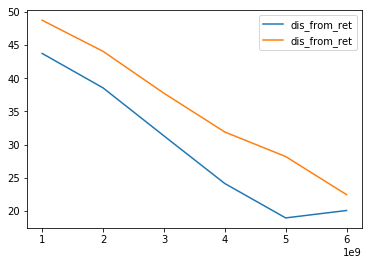

In [315]:
plt.plot(df_grouped.loc[df_grouped['outcome']=='fair_catch']['time_since_punt'], df_grouped.loc[df_grouped['outcome']=='fair_catch']['dis_from_ret'])
plt.plot(df_grouped.loc[df_grouped['outcome']=='return']['time_since_punt'], df_grouped.loc[df_grouped['outcome']=='return']['dis_from_ret'])
plt.legend()

In [322]:
pos_grouped_df = cov_ret_df.groupby(['cov_Role','time_since_punt', 'outcome'], as_index=False)['dis_from_ret'].mean()

In [325]:
trace1 = go.Bar(
        x=pos_grouped_df.loc[pos_grouped_df.outcome == 'fair_catch']['cov_Role'],
        y=pos_grouped_df.loc[pos_grouped_df.outcome == 'fair_catch']['dis_from_ret'],
        name='fair catch'
    )

trace2 = go.Bar(
        x=pos_grouped_df.loc[pos_grouped_df.outcome == 'return']['cov_Role'],
        y=pos_grouped_df.loc[pos_grouped_df.outcome == 'return']['dis_from_ret'],
        name='return'
    )

data = [trace1, trace2]
layout = go.Layout(
    barmode='group',
    xaxis=dict(title='Position'),
    yaxis= dict(title='Avg Distance From Returner (Yds)')
)

fig=go.Figure(data=data, layout=layout)
py.iplot(fig, filename='grouped-bar')

In [ ]:
df.groupby(['position','seconds'], as_index = False)['distance'].agg({'Count': 'count', 'mean_distance': np.mean, 'median_distance':np.median}) \
    .sort_values(['seconds', 'Count'], ascending = [True, False]).reset_index(drop=True)